In [2]:
import numpy as np
from scipy.stats import pearsonr
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import itertools
from ipywidgets import *

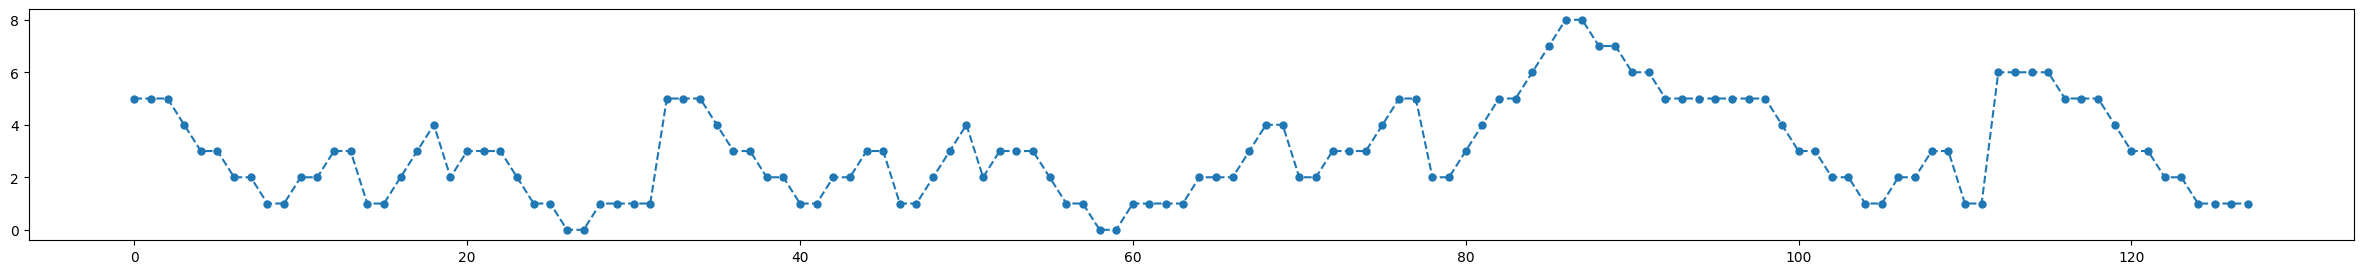

In [3]:
notes=[]
ss= '5  43 2 1 2 3 1 23423  21 0 1   5  43 2 1 2 3 1 23423  21 0 1   2  34 2 3  45 2 345 678 7 6 5   5  43 2 1 2 3 1 66665  43 2 1   '
for elem in ss:
    if elem.isnumeric():
        notes.append(int(elem))
    else:
        notes.append(notes[-1])

notes=np.array(notes)
m = notes.size
        
plt.figure(figsize=(30,3))
plt.plot(notes,linestyle='--', marker='.',markersize=10)

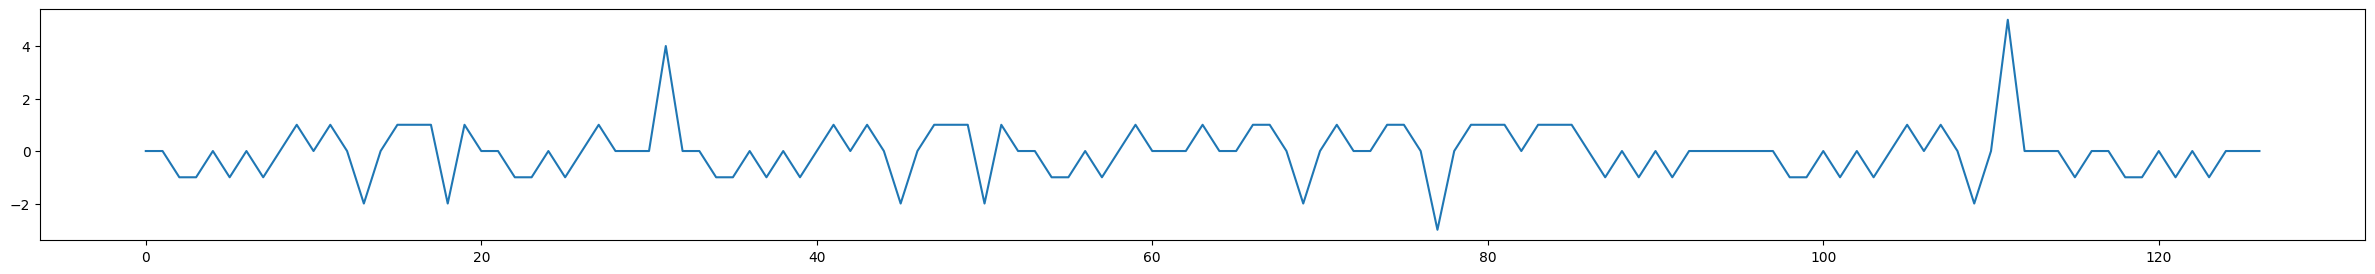

In [4]:
intervals = notes[1:] - notes[:-1]
plt.figure(figsize=(30,3))
plt.plot(intervals)
dataset=intervals

### The Class motif learning

In [193]:
class MotifLearner:

    def __init__(
        self,  
        sim_thresh=1, 
        freq_thresh=2, 
        l_motif_range = [4,20],
    ):
        self.dataset = dataset
        self.sim_thresh = sim_thresh
        self.freq_thresh = freq_thresh
        self.l_motif_range = l_motif_range
        self.iterator = range(self.l_motif_range[0], self.l_motif_range[1])
        self.m = len(self.dataset)
        
    def sim(self, u, v):
        """ Computes the Matching similarity function between two given vectors

        Parameters
        ----------
        X : {int-list}
        Y : {int-list} of same length as X

        Returns
        -------
        similarity : {float} that equals the propotion of matching entries between X and Y.

        """
        return sum([i==j for i, j in zip(u,v)])/len(u)

    def sim_matrix(self, l_motif):
        """ Computes the l_motif similarity matrix on a given dataset 

        Parameters
        ----------
        self.dataset : {array-like} of shape (n_samples,) containing the Training data time-series.
        l_motif : {int} specifying the motif length

        Returns
        -------
        similarity matrix: {float-matrix} of shape (n_samples, n_samples). Similarity matrix for the dataset for motifs of length l_motif

       """
        sim_mtx = np.zeros((self.m-l_motif,self.m-l_motif))
        for i in range(self.m-l_motif):
            for j in range(self.m-l_motif):
                u = self.dataset[i:i+l_motif]
                v = self.dataset[j:j+l_motif ]
                sim_mtx[i,j] = self.sim(u,v)
        sim_mtx = np.pad(sim_mtx, [(0, l_motif), (0, l_motif)], mode='constant', constant_values=0)
        return sim_mtx
    
    def frequent_motifs(self):
        """ Method for finding motifs in the dataset in the given range of motif lengths

        Parameters
        ----------
        self.dataset : {array-like} of shape (n_samples,) containing the Training data time-series.
        self.sim_thresh : {float} specifies the threshold for the similarity matrix. Only if the similarity is greater than or equal to sim_thresh, will the motifs be considered equivalent
        self.freq_thresh: {int} specifies the minimum number of occurences for motif to considered frequent  
        self.l_motif_range: {int-list} of size 2. Specifies the range in which to search for motifs of length.

        Returns
        -------
        frequent : {dict} that contains information of the frequent motifs, their start-point in the data, and their frequencies in the form:
                    {
                    1: {start_1_motif_1: freq of 1_motif_1, start_1_motif_2: freq of 1_motif_2, ...}
                    2: {start_2_motif_1: freq of 2_motif_1, start_2_motif_2: freq of 2_motif_2, ...}
                    .
                    .
                    .
                    l_motif: start_l_motif_1: freq of l_motif_1, start_l_motif_2: freq of l_motif_2, ...}
                    .
                    .
                    .
                    }
                    if there are no motifs of length l_i, then the corresponding value for entry l in dictionary is an empty dictionary

        """
        self.frequent={}
        for i in self.iterator:
            self.frequent[i]={}

        for l_motif in self.iterator:
            M = self.sim_matrix(l_motif) >= self.sim_thresh
            M = sparse.csr_matrix(M)
            sparse.csr_matrix.setdiag(M,0)
            def is_lonely_point(i,j):  ### Function inside: should we define this as a separate method outside? but then M would need to be an argument
                if i==0 or j==0:
                    return not (M[i+1,j+1])
                if i==M.shape[0]-1 or j==M.shape[0]-1:
                    return not (M[i-1,j-1])
                return not (M[i+1,j+1] or M[i-1,j-1]) 

            row, _ = M.nonzero()
            rows = set(row)
            while rows:
                i = rows.pop()
                c_lonely = 0
                c_total = 0
                for j in M[i,:].nonzero()[1]:
                    if is_lonely_point(i,j):
                        c_lonely+=1
                    else:
                        c_total+=1
                if c_lonely >= self.freq_thresh:
                    c_total+=c_lonely
                    self.frequent[l_motif][i]=c_total+1
                    for point in M[i,:].nonzero()[1]: 
                        try:
                            rows.remove(point)
                        except:
                            pass

        return self.frequent
    
    def get_motifs(self, plot=False):
        """ Method that returns the actual motifs

        Parameters
        ----------
        plot : {bool} True creates plots of each of the frequent l-motifs
        
        Returns
        -------
        self : {list} of frequent motifs 

        """
        self.motif_list = []
        for l_motif in self.iterator:
            if self.frequent[l_motif]!={}:
                if plot:
                    plt.figure()
                for key in self.frequent[l_motif]:
                    self.motif_list.append(list(self.dataset[key:key+l_motif]))
                    if plot:
                        plt.plot(dataset[key:key+l_motif])
                        plt.title(f'{l_motif}-motifs')
        return self.motif_list
    
    def _is_submotif(self, big_motif,small_motif):
        """ Checks whether a smaller motif is a submotif of a bigger motif

        Parameters
        ----------
        big_motif : {list} containing the bigger motif
        small_motif: {list} containing the smaller motif
        
        Returns
        -------
        is_submotif: {bool} 
        
        """
        for i, _ in enumerate(big_motif):
            if np.array_equal(big_motif[i:i+len(small_motif)],small_motif):
                return True
        return False
    
    def motif_composition(self):
        """ Finds whether certain bigger motifs are composed of smaller motifs
        
        Parameters
        ----------
        self
        
        Returns
        -------
        motif_comp: {dict} with keys represnting motifs indices as in self.motif_list. 
                    The value of each key contains a {list} of motif indices that are submotifs of the key motif
        """
        self.motif_comp = {}
        for i, big_motif in reversed(list(enumerate(self.motif_list))):
            self.motif_comp[i]=[]
            for j in range(i):
                small_motif = self.motif_list[j]
                if self._is_submotif(big_motif,small_motif):
                    self.motif_comp[i].append(j)
        return self.motif_comp

    def fit(self, dataset):
        """ 
        Parameters
        ----------
        Returns
        -------
        self : object
        Fitted estimator.

        """
        self.frequent = self.frequent_motifs()
        self.motif_list = self.get_motifs()
        self.motif_comp = self.motif_composition()
        return self

    def pruned_motifs(self):
        """ Creates a pruned list of motifs by removing motifs that occur as submotifs.
        Parameters
        ----------
        self
        
        Returns
        -------
        pruned_motif_list: {list} if frequent motifs that are not sub motifs of other motifs
        
        """
        sub_motifs = set()
        for i in self.motif_comp:
            sub_motifs = sub_motifs.union(set(self.motif_comp[i]))
        self.pruned_motif_list = [i for j, i in enumerate(mfl) if j not in list(sub_motifs)] 
        return self.pruned_motif_list

    def matrix_plot(self):
        """
        Method that plots and visualises the similarity matrix for the given dataset and sim_thresh
        
        Parameters
        ----------
        
        Returns
        -------
        self : {interatcive_plot}
        
        """
        def mplot(l_motif):
            sim_mtx = self.sim_matrix(l_motif) >= self.sim_thresh
            plt.figure(figsize=(8,10))
            plt.imshow(sim_mtx,cmap='Greys')
            plt.show()
            return sim_mtx

        interactive_plot = interactive(mplot, l_motif=(1, 40))
        output = interactive_plot.children[-1]
        return interactive_plot
    
    def plot_motif_appearances(self, pruned=True, time_series=dataset):
        """
        Plots the appearnces of the frequent motifs in the dataset
        
        Parameters
        ----------
        pruned : {bool} True means that it selects only the motifs that are not sub-motifs of any other motif
        time_serires : If time series is given as input, then the appearances will be plotted on this time series, 
                        and not the dataset. Note however that the ocurrences are located on the dataset 
        
        Returns
        -------
        """
        def plot_single_motif(motif):
            plt.figure(figsize=(60,3))
            plt.plot(np.arange(len(time_series)), time_series,c='b', linestyle='--')
            for i, _ in enumerate(self.dataset[:-len(motif)]):
                if self.sim(self.dataset[i:i+len(motif)], motif)>= self.sim_thresh:
                    plt.scatter(np.arange(i,i+len(motif)), time_series[i:i+len(motif)], c=['r']+['g']*(len(motif)-1),s=45)

        if pruned:
            self.pruned_motif_list=self.pruned_motifs()
            for motif in self.pruned_motif_list:
                plot_single_motif(motif)
        else:
            for motif in self.motif_list:
                plot_single_motif(motif)

In [194]:
motifl = MotifLearner(
        sim_thresh=1, 
        freq_thresh=2, 
        l_motif_range = [4,20])
motifl.fit(dataset)
motifl.get_motifs()

[[-1, 0, -1, 0],
 [0, 1, 1, 1],
 [0, 1, 0, 0],
 [0, -1, 0, 0],
 [1, 0, -2, 0, 1],
 [0, -1, 0, -1, 0],
 [-1, 0, -1, 0, 1, 0],
 [-1, 0, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -2, 0]]

In [195]:
motifl.pruned_motifs()

[[0, 1, 1, 1],
 [0, 1, 0, 0],
 [0, -1, 0, 0],
 [1, 0, -2, 0, 1],
 [0, 0, -1, -1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -2, 0]]

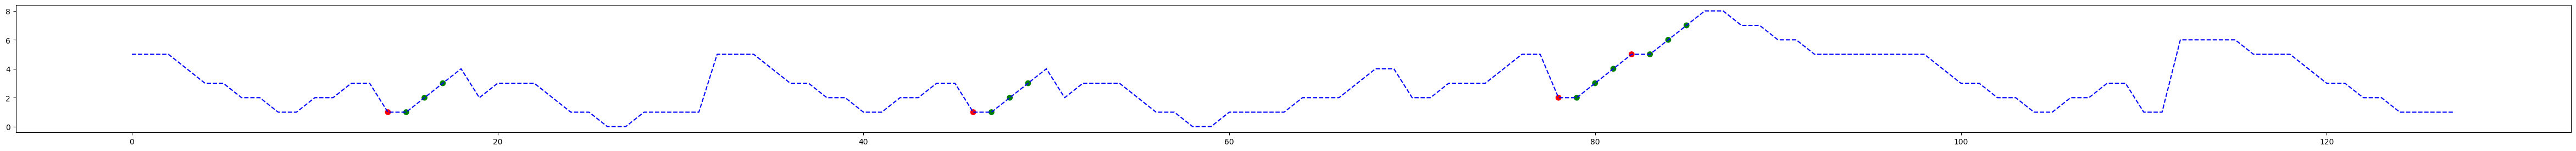

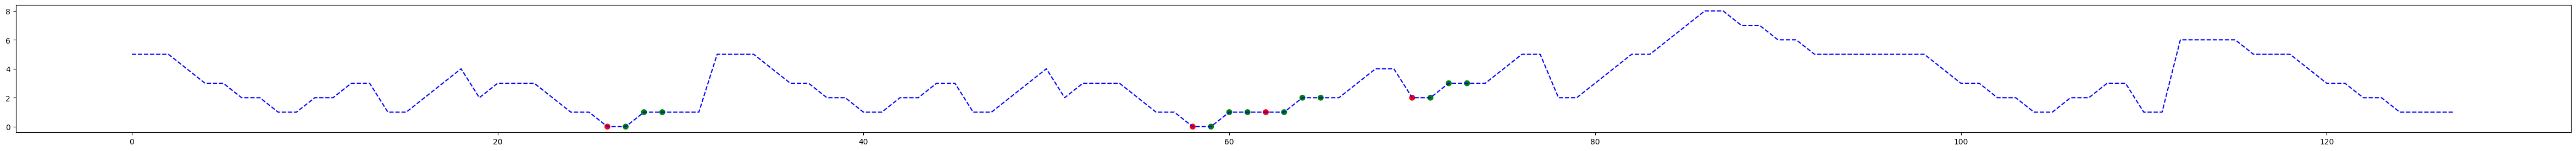

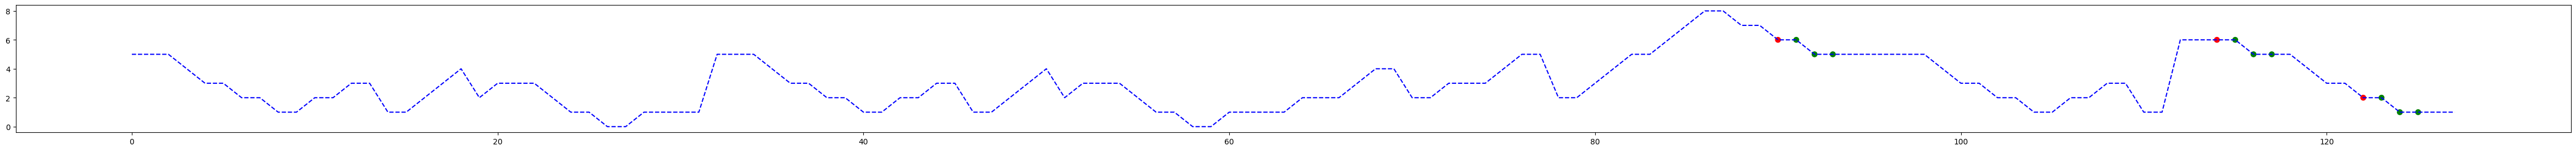

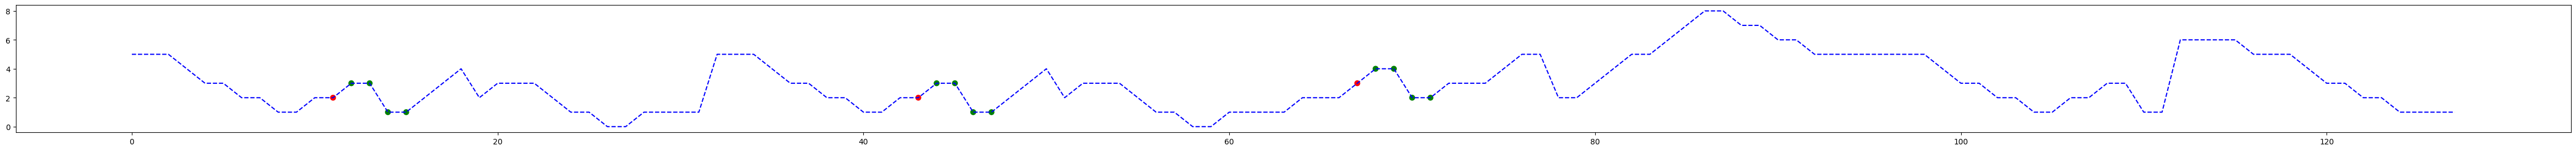

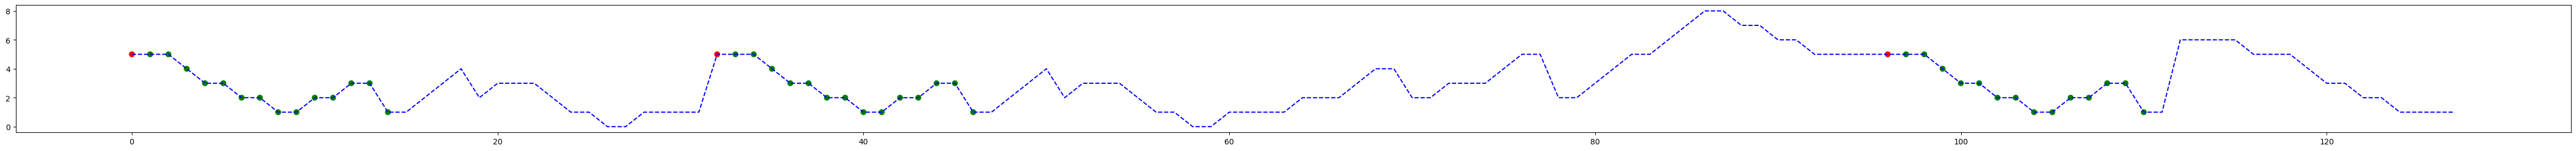

In [200]:
motifl.plot_motif_appearances(time_series=notes)

In [68]:
#motifl.get_motifs(plot=True)

----------------

### Some visualisations

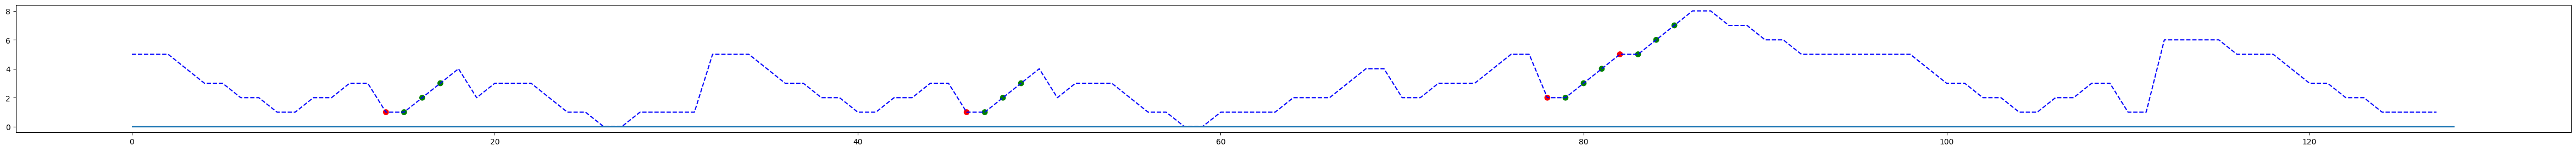

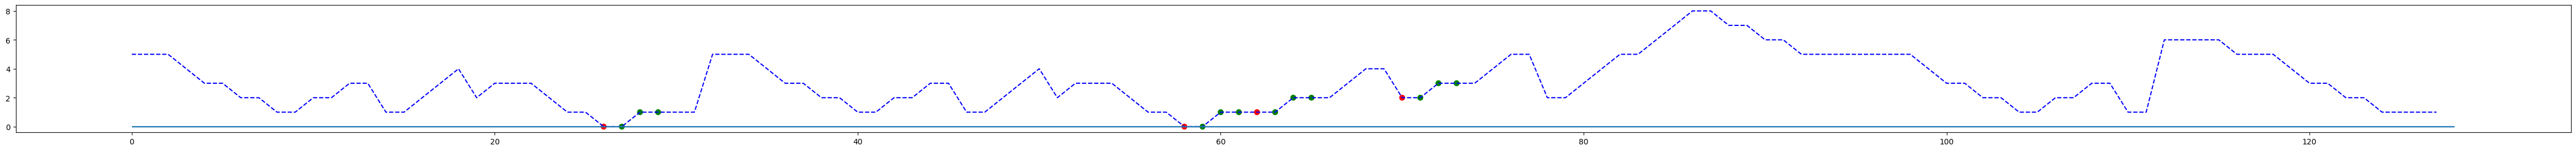

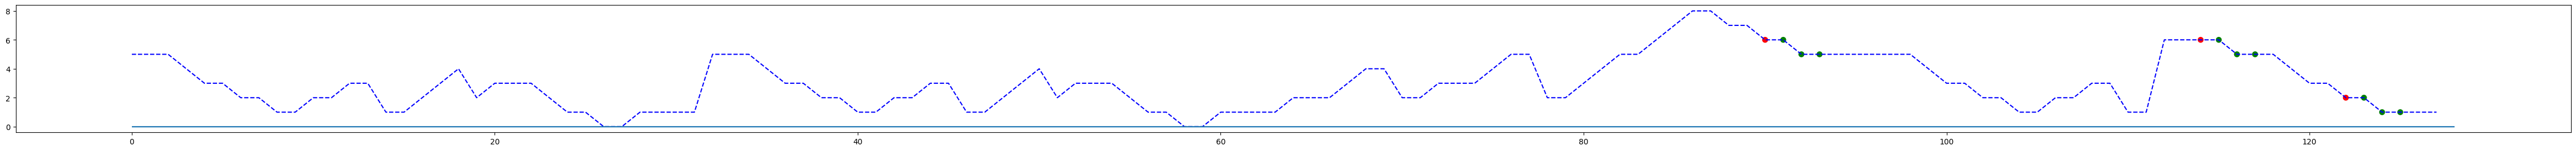

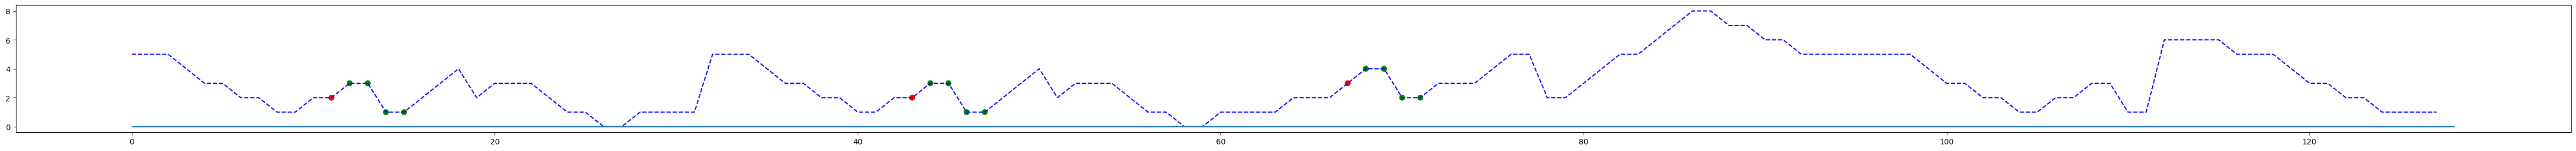

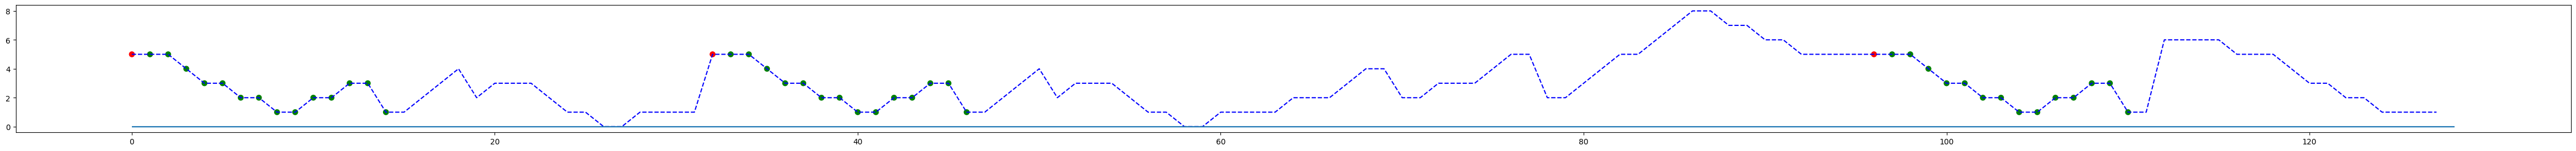

In [15]:
def plot_motif_appearances_notes(motif):
    plt.figure(figsize=(60,3))
    plt.plot(np.arange(len(notes)), notes,c='b', linestyle='--')
    for i, _ in enumerate(dataset[:-len(motif)]):
        if sim(dataset[i:i+len(motif)], motif)==1:
            plt.scatter(np.arange(i,i+len(motif)),notes[i:i+len(motif)], c=['r']+['g']*(len(motif)-1),s=45)
            plt.hlines(y=0,xmin=0, xmax=len(notes))

for l_motif in iterator:    
    for key in frequent[l_motif]:
        motif = dataset[key:key+l_motif]
        plot_motif_appearances_notes(motif)